## Assignment: Convolution using Toeplitz Matrix

---


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.signal as sig

### Reading the image

Reading the image as gray scale image using `IMREAD_GRAYSCALE`/`0` flag.

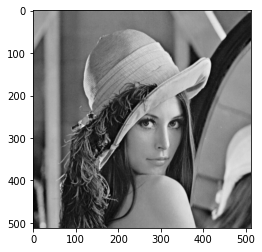

In [2]:
img = cv2.imread('../images/lena.png', 0)
plt.imshow(img, cmap='gray')
plt.show()

### Resizing the image

Resizing the image from `512x512` to `256x256` using `cv2.resize()`. 

Otherwise it would be too large for the GPU to handle.

Required memory for an image of size `512x512` would be `66GiB` at the minimum.

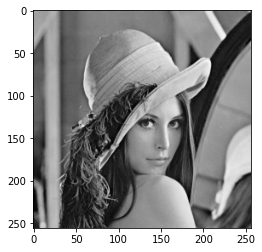

(256, 256)


In [3]:
resized_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
plt.imshow(resized_img, cmap='gray')
plt.show()

print(resized_img.shape)

### Defining the kernel(Filter) and 

Difining the kernel as a `3x3` matrix.
Calculating the padding size for the kernel.

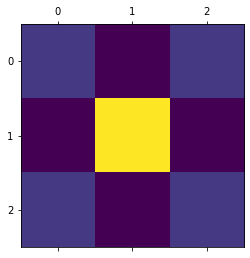

In [4]:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.int8)
kernel_size = kernel.shape[0]
padding = (kernel_size - 1) // 2

plt.matshow(kernel)
plt.show()

### Paddding the image with boundary values

Padding the image with boundary values(`cv2.BORDER_REPLICATE`).

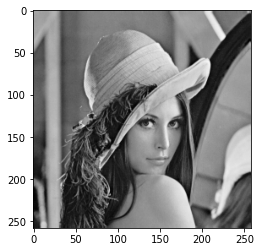

In [5]:
padded_img = cv2.copyMakeBorder(resized_img, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
plt.imshow(padded_img, cmap='gray')
plt.show()

### Image & Kernel Shape

In [6]:
image_row, image_col = padded_img.shape[:2]
kernel_row, kernel_col = kernel.shape[:2]

### Calculating output dimensions

In [7]:
output_row = image_row + kernel_row - 1
output_col = image_col + kernel_col - 1
output_shape = (output_row, output_col)
print("Output shape: ", output_shape)

Output shape:  (260, 260)


### Zero padding the kernel

Zero padding the kernel to make it of size `260x260`(same as output shape) using `np.pad()`.

In [8]:
zero_padded_filter = np.pad(kernel, ((output_row - kernel_row, 0), (0, output_col - kernel_col)), 'constant', constant_values=0)
print(zero_padded_filter)
print("Shape of zero padded filter: ", zero_padded_filter.shape)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0 -1  0 ...  0  0  0]
 [-1  5 -1 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]]
Shape of zero padded filter:  (260, 260)


### Toeplitz Matrix

Making a list of toeplitz matrices for each row.

In [9]:
toeplitz_list = []

for i in range(zero_padded_filter.shape[0] -1, -1, -1):
    c = zero_padded_filter[i, :]
    r = np.r_[c[0], np.zeros(image_col - 1, dtype=np.int8)]
    toeplitz_list.append(la.toeplitz(c, r))

# print(toeplitz_list)
print("Length of toeplitz list: ", len(toeplitz_list))

Length of toeplitz list:  260


### Doubly Toeplitz Matrix

In [10]:
c = range(1, zero_padded_filter.shape[0] + 1)
r = np.r_[c[0], np.zeros(image_col - 1, dtype=np.int8)]
doubly_toeplitz = la.toeplitz(c, r)

print(doubly_toeplitz)
print(doubly_toeplitz.shape)
print(doubly_toeplitz.size)

[[  1   0   0 ...   0   0   0]
 [  2   1   0 ...   0   0   0]
 [  3   2   1 ...   0   0   0]
 ...
 [258 257 256 ...   3   2   1]
 [259 258 257 ...   4   3   2]
 [260 259 258 ...   5   4   3]]
(260, 258)
67080


### Doubly Block Toeplitz Matrix

In [11]:
h = toeplitz_list[0].shape[0] * doubly_toeplitz.shape[0]
w = toeplitz_list[0].shape[1] * doubly_toeplitz.shape[1]

doubly_blocked_toeplitz = np.zeros((h, w), dtype=np.int16)

print(doubly_blocked_toeplitz)
print(doubly_blocked_toeplitz.shape)
print(doubly_blocked_toeplitz.size)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(67600, 66564)
4499726400


### Filling the Doublly Block Toeplitz Matrix

In [12]:
for i in range(toeplitz_list[0].shape[0]):
    for j in range(toeplitz_list[0].shape[1]):
        r_start = i * toeplitz_list[0].shape[0]
        r_end = r_start + toeplitz_list[0].shape[0]
        c_start = j * toeplitz_list[0].shape[1]
        c_end = c_start + toeplitz_list[0].shape[1]
        doubly_blocked_toeplitz[r_start:r_end, c_start:c_end] = toeplitz_list[doubly_toeplitz[i, j] - 1]

print(doubly_blocked_toeplitz)

[[ 0  0  0 ...  0  0  0]
 [-1  0  0 ...  0  0  0]
 [ 0 -1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0 -1  0]
 [ 0  0  0 ...  0  0 -1]
 [ 0  0  0 ...  0  0  0]]


### Converting the image to a vector of size `256x256`

In [13]:
def matrix_to_vector(matrix):
    height, width = matrix.shape[:2]
    vector = np.zeros(height * width, dtype=np.int16)

    matrix = np.flipud(matrix)
    for i, row in enumerate(matrix):
        vector[i * width : i * width + width] = row
    
    return vector

In [14]:
vectorized_image = matrix_to_vector(padded_img)

print(vectorized_image)
print(vectorized_image.shape)
print(vectorized_image.size)

[ 53  53  63 ... 177 150 150]
(66564,)
66564


### Performing convolution as a matrix multiplication

Matrix multiplication using `np.matmul()`.

In [15]:
result = np.matmul(doubly_blocked_toeplitz, vectorized_image)
print("Result: ", result)

Result:  [   0  -53  -53 ... -150 -150    0]


### Converting back the vector to an image (matrix)

In [16]:
def vector_to_matrix(vector, shape):
    height, width = shape[:2]
    matrix = np.zeros(shape, dtype=np.int16)

    for i in range(height):
        matrix[i, :] = vector[i * width : i * width + width]
    
    return np.flipud(matrix)

### Showing the result and comparing with the existing library functions.

 Comparison with `cv2.filter2D()` & `signal.convolve2d()`

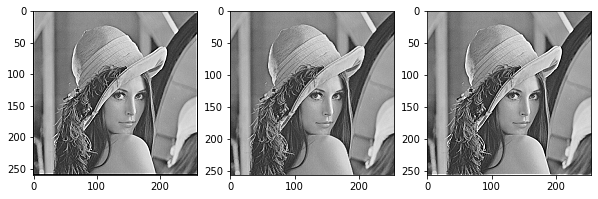

In [17]:
output_image = vector_to_matrix(result, output_shape)
filtered_image = cv2.filter2D(resized_img, -1, kernel, borderType=cv2.BORDER_REPLICATE)
convolved_image = sig.convolve2d(resized_img, kernel, mode='same')

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(output_image, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(filtered_image, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(convolved_image, cmap='gray', vmin=0, vmax=255)
plt.show()

### Visualizing the result with `plt.hist()`

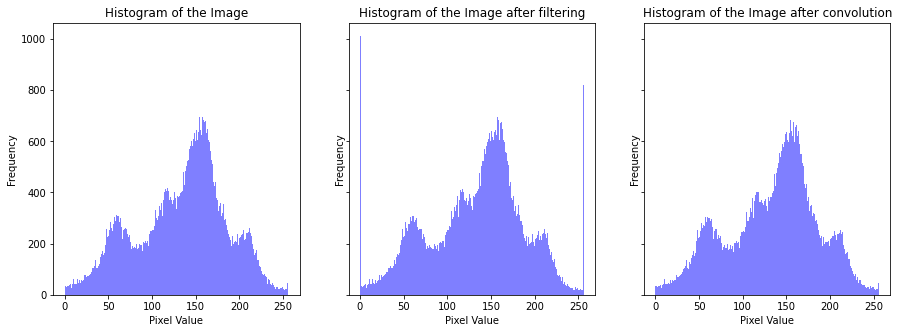

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True, )

axes[0].hist(output_image.ravel(), bins=256, range=(0, 256), alpha=0.5, color='blue')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of the Image')

axes[1].hist(filtered_image.ravel(), bins=256, range=(0, 256), alpha=0.5, color='blue')
axes[1].set_xlabel('Pixel Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of the Image after filtering')

axes[2].hist(convolved_image.ravel(), bins=256, range=(0, 256), alpha=0.5, color='blue')
axes[2].set_xlabel('Pixel Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of the Image after convolution')

plt.show()